In [1]:
import sys
sys.path.append('.')

In [2]:
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
import math
import importlib
import torch
from torch.utils.data import DataLoader
from lib.datamodule import PressurePoseDataModule, BodiesAtRestDataModule, SLPDataModule, SoftlineDataModule
from lib.F import mpjpe, per_joint_mean_position_errors, per_joint_position_errors, pcp, per_part_correct_percentage, pck, per_keypoint_correct_percentage
from lib.viz import plot_results, plot_mattress
from lib.transforms import SkeletonCleverToCommon, SkeletonSLPToCommon, HeatmapsToSkeleton, SkeletonToHeatmaps, StdMeanNormalize, HistogramEqualize, Stack, Boolean
from lib.constants import constants

In [3]:
LOG_FOLDER = "tb_logs"
MODEL = "unet"
VERSION = "version_5"
CHECKPOINT = "best.ckpt"
SET = 'test'

In [4]:
simple_cnn = importlib.import_module("unet")
net = simple_cnn.Net.load_from_checkpoint(f"{LOG_FOLDER}/{MODEL}/{VERSION}/checkpoints/{CHECKPOINT}")
net

Net(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [5]:
JOINT_REMAPPING = [12, 9, 8, 3, 2, 4, 1, 5, 0, 10, 7, 11, 6]
PART_REMAPPING = [2, 1, 3, 0, 6, 5, 7, 4]

In [6]:
def evaluate():
    global net, dm, y, y_hat
    dm.setup()
    dm_skel.setup()
    
    skelset = dm_skel.test_set if SET == 'test' else dm_skel.val_set
    loader = dm.test_dataloader() if SET == 'test' else dm.val_dataloader()
    loader.shuffle=False
    
    y = torch.Tensor(np.asarray(
            [np.asarray(x, dtype=np.float32) for x in skelset.index['skeleton']]
    )).reshape(-1, constants.JOINTS, 2)
    y_hat = np.empty((0, constants.JOINTS, 2))
    
    for X_b, o_b in loader:
        o_hat_b = net(X_b).detach().numpy()
        y_hat_b = np.asarray([HeatmapsToSkeleton()(x) for x in o_hat_b])
        y_hat = np.append(y_hat, y_hat_b, axis=0)
        
    y_hat = torch.Tensor(y_hat)

In [7]:
def print_metrics():
    global y, y_hat
    pjpe = per_joint_position_errors(y_hat, y)
    print(f"Mean per-joint position error: {mpjpe(y_hat, y)} cm ± {torch.std(pjpe)} cm")
    print(f"PCP: {pcp(y_hat, y)*100} %")
    print(f"PCK: {pck(y_hat, y)*100} %")
    pjmpe = per_joint_mean_position_errors(y_hat, y)
    for index in range(constants.JOINTS):
        i = JOINT_REMAPPING[index]
        print(f"Mean position error for {constants.LABELS[i]}: {pjmpe[i]} cm ± {torch.std(pjpe[i])} cm")
    ppcp = per_part_correct_percentage(y_hat, y)
    for index in range(len(constants.PARTS)):
        i = PART_REMAPPING[index]
        print(f"Percentage of correct {constants.PARTS[i]}s: {ppcp[i]*100} %")
    pkcp = per_keypoint_correct_percentage(y_hat, y)
    for index in range(constants.JOINTS):
        i = JOINT_REMAPPING[index]
        print(f"Percentage of correct {constants.LABELS[i]}s: {pkcp[i]*100} %")

In [8]:
def plot_examples():
    global X, y, y_hat

    plt.rcParams.update({'font.size': 12})
    fig, axes = plt.subplots(3, 5)
    fig.set_size_inches(20, 20)
    
    X_b, y_b = next(iter(dm.test_dataloader() if SET == 'test' else dm.val_dataloader()))
    
    random.seed(4242)
    for i in range(3):
        for j in range(5):
            index = int(random.random()*256) % len(X_b) # 3*i+j
            plot_results(
                X_b[index][0],
                [y[index].reshape(-1,2), y_hat[index].reshape(-1,2)],
                ax=axes[i][j]
            )

In [9]:
def plot_heatmap_example(sample):
    global dm
    
    plt.rcParams.update({'font.size': 12})
    fig, axes = plt.subplots(3, 5)
    fig.set_size_inches(20, 20)
    
    X_b, y_b = next(iter(dm.test_dataloader() if SET == 'test' else dm.val_dataloader()))
    heatmaps = net(X_b).detach().numpy()[sample]
    
    for i in range(len(heatmaps)):
        ax = axes[int(i/5)][i%5]
        heatmap = heatmaps[i]
        plot_results(heatmap, [y[sample]], ax=ax, skeleton_col='green')
        ax.set_title(constants.LABELS[i])
    plot_results(X_b[sample][0], [y[sample]], ax=axes[2][3], skeleton_col='green')
    axes[2][3].set_title("Pressure image")

In [10]:
def plot_per_joint_position_errors():
    global y, y_hat
    
    errors = per_joint_position_errors(y_hat, y)

    plt.rcParams.update({'font.size': 30})
    fig, axes = plt.subplots(2, 7)
    fig.set_size_inches(40, 10)
    
    for i in range(2):
        for j in range(7):
            index = 7*i+j
            if index >= constants.JOINTS:
                break
            index = JOINT_REMAPPING[index]
            sns.kdeplot(errors[index].numpy(), ax=axes[i][j], fill=True)
            axes[i][j].set_title(constants.LABELS[index])
            axes[i][j].tick_params(left=False, labelleft=False, labelbottom=False)
            axes[i][j].set_ylabel(None)
    sns.kdeplot(errors.reshape(-1).numpy(), ax=axes[1][6], fill=True)
    axes[1][6].set_title('Overall')
    axes[1][6].tick_params(labelleft=False, labelbottom=False)
    axes[1][6].set_ylabel(None)
    plt.setp(axes, xlim=(0, 50), xticks=(0, 50), ylim=(0, 0.4))

# Validation Dataset

In [11]:
dm = PressurePoseDataModule(
    train_data_file = 'data/data-train.pkl',
    val_data_file = 'data/data-val.pkl',
    test_data_file = 'data/data-test.pkl',
    input_format='ref',
    target_format='heatmaps',
    num_workers=8,
    input_transform = Stack([StdMeanNormalize(), Boolean(), HistogramEqualize()])
)
dm_skel = PressurePoseDataModule()
evaluate()

In [12]:
print_metrics()

Mean per-joint position error: 7.398468494415283 cm ± 9.507619857788086 cm
PCP: 84.60437774658203 %
PCK: 86.85831451416016 %
Mean position error for Thorax: 3.7112135887145996 cm ± 2.373939275741577 cm
Mean position error for Left shoulder: 5.518637657165527 cm ± 3.699653148651123 cm
Mean position error for Right shoulder: 5.358909606933594 cm ± 3.589998245239258 cm
Mean position error for Left hip: 4.293456077575684 cm ± 2.3010001182556152 cm
Mean position error for Right hip: 4.325671672821045 cm ± 2.53347110748291 cm
Mean position error for Left knee: 5.2632975578308105 cm ± 4.728421211242676 cm
Mean position error for Right knee: 5.833668231964111 cm ± 5.637397289276123 cm
Mean position error for Left ankle: 6.531599044799805 cm ± 8.678705215454102 cm
Mean position error for Right ankle: 6.295274257659912 cm ± 7.7634172439575195 cm
Mean position error for Left elbow: 8.83398723602295 cm ± 11.158268928527832 cm
Mean position error for Right elbow: 8.709413528442383 cm ± 9.9985475540

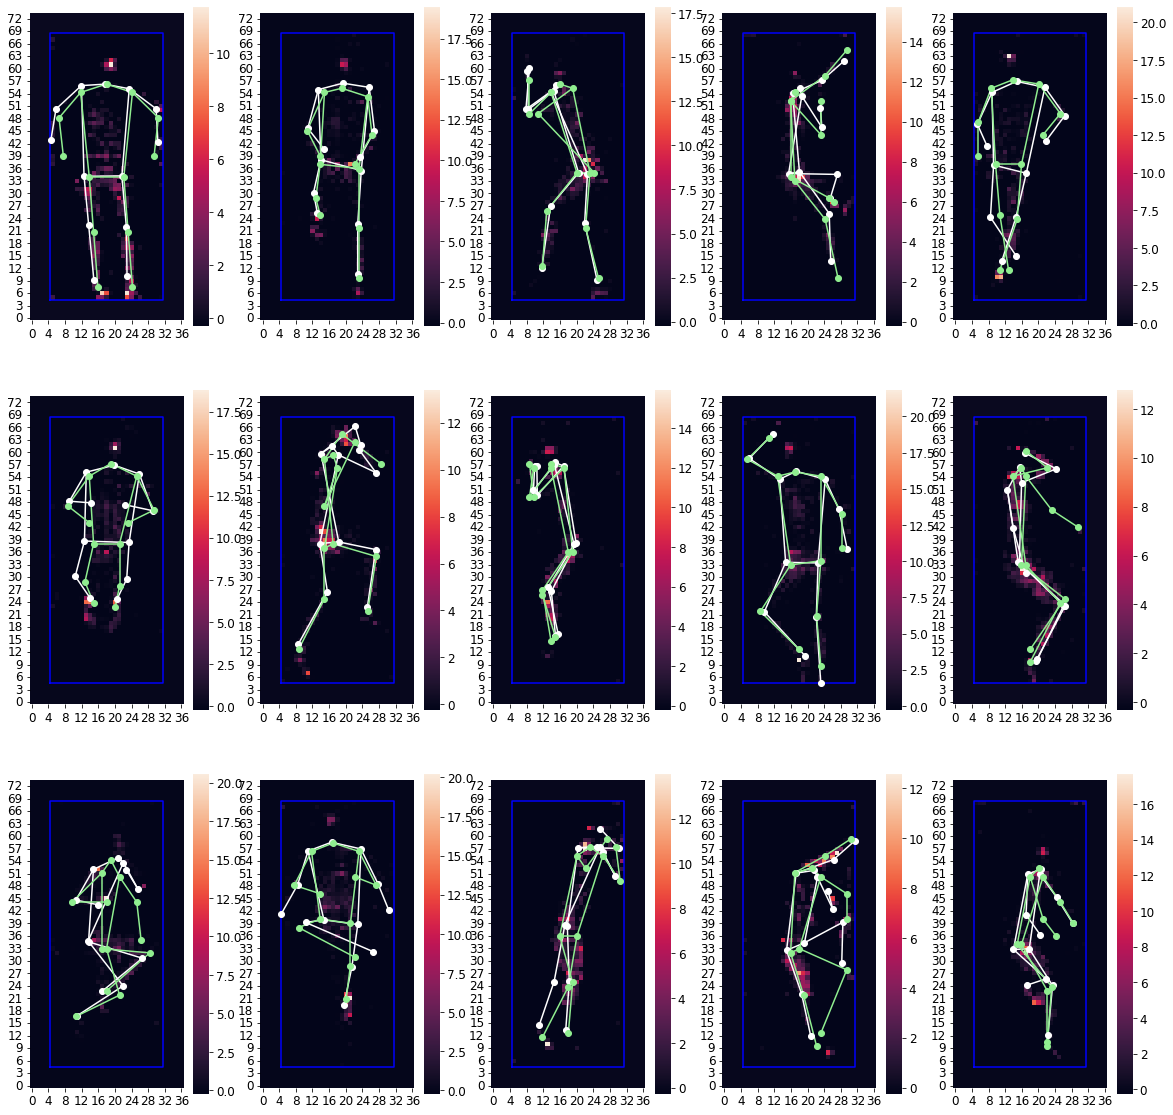

In [13]:
plot_examples()

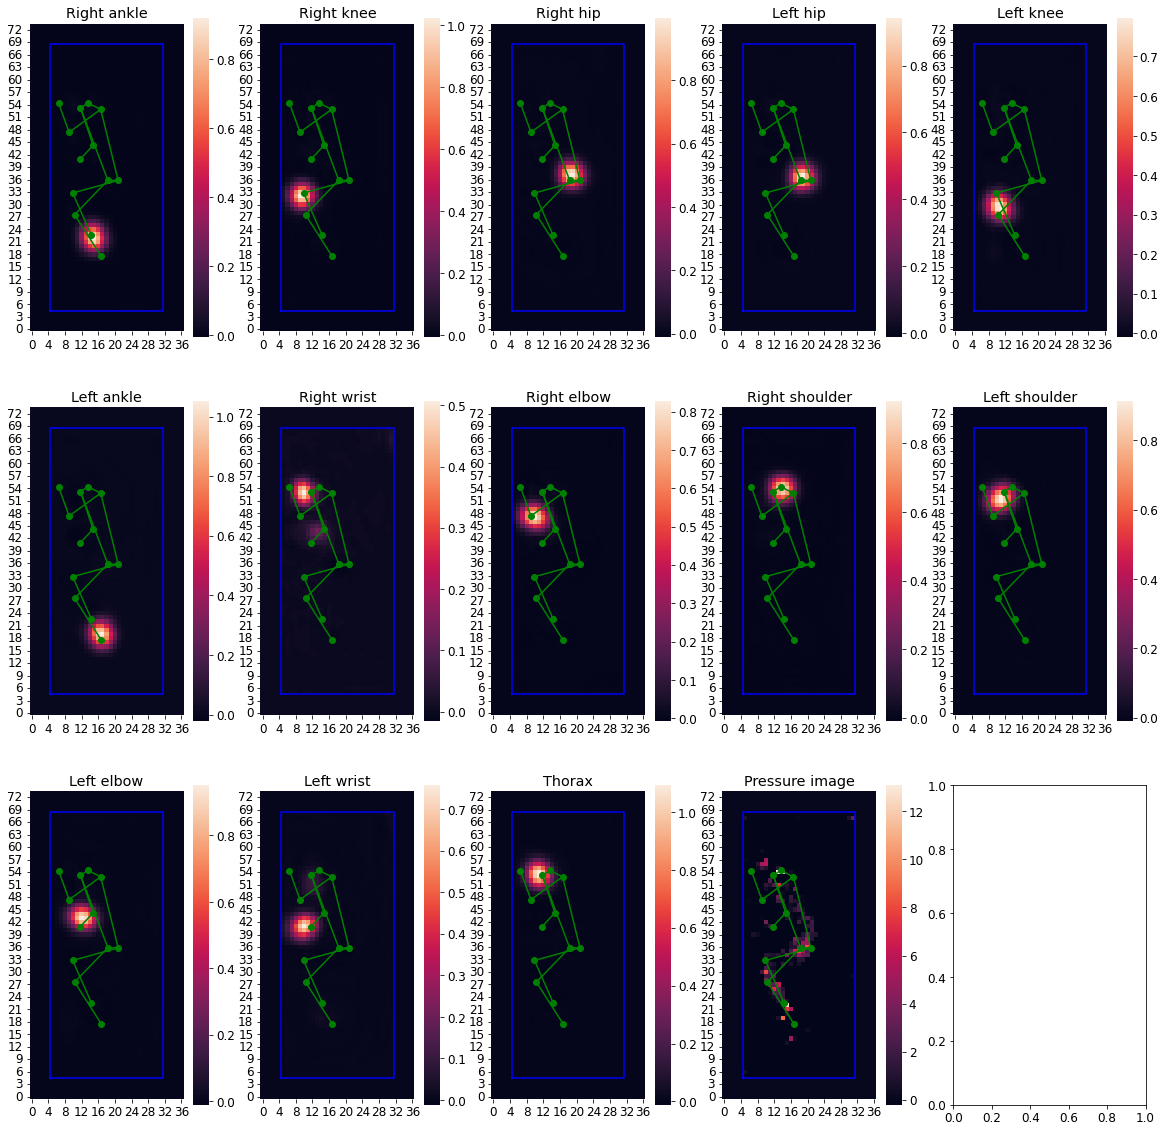

In [14]:
plot_heatmap_example(4)

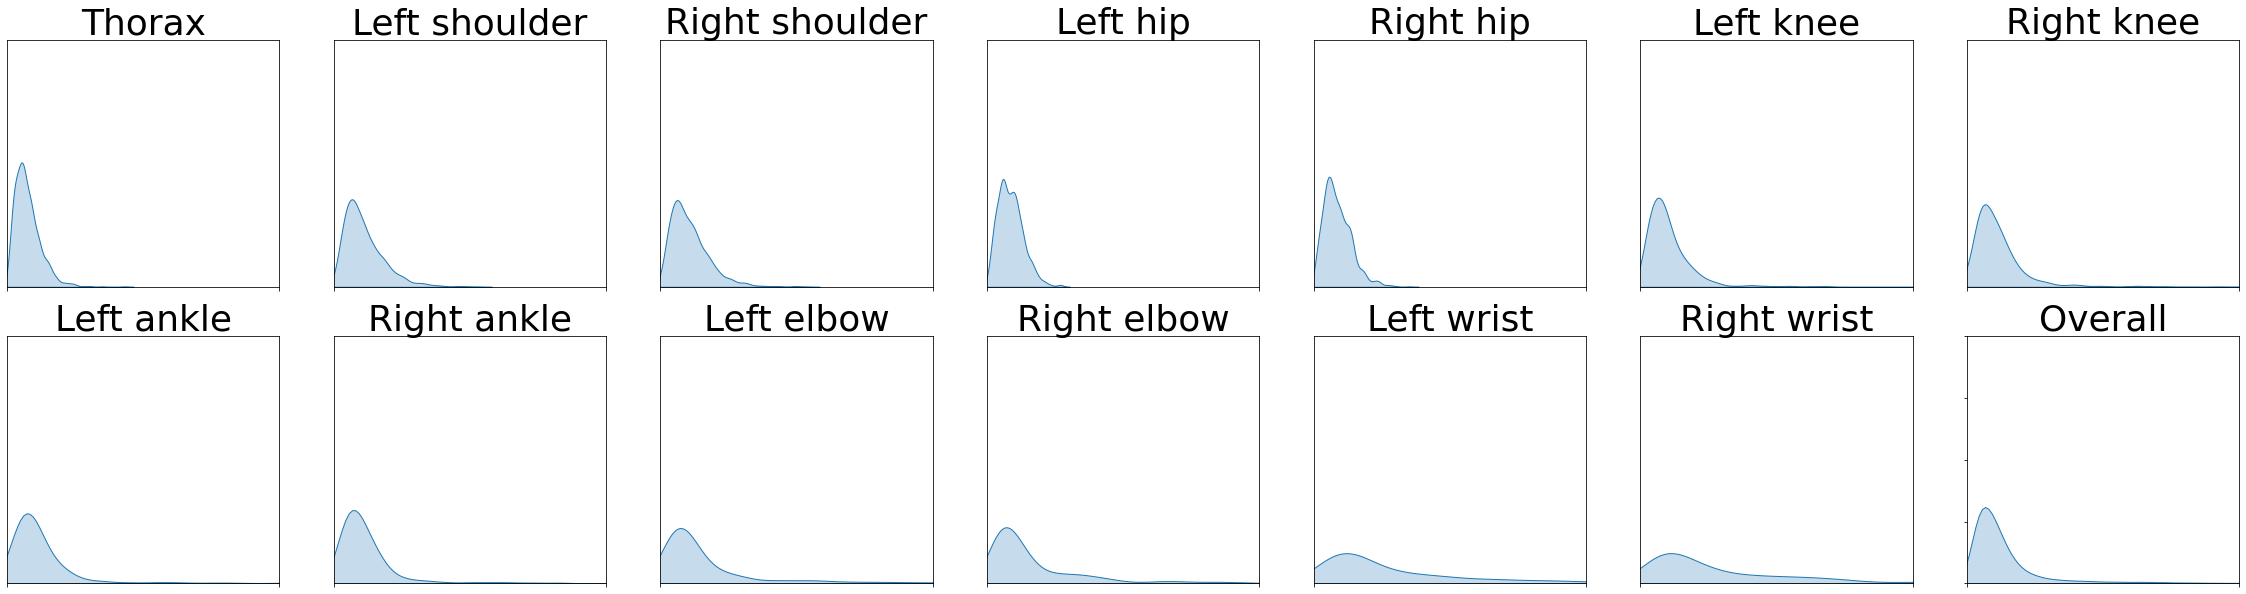

In [15]:
plot_per_joint_position_errors()

# Bodies-at-Rest Dataset

In [16]:
dm = BodiesAtRestDataModule(
    train_data_file = 'data/bodies-at-rest/data-train.pkl',
    val_data_file = 'data/bodies-at-rest/data-val.pkl',
    test_data_file = 'data/bodies-at-rest/data-test.pkl',
    image_dir = 'data/bodies-at-rest',
    input_format='ref',
    target_format='heatmaps',
    num_workers=8,
    input_transform = Stack([StdMeanNormalize(), Boolean(), HistogramEqualize()])
)
dm_skel = BodiesAtRestDataModule(target_transform=SkeletonCleverToCommon())
evaluate()

In [17]:
print_metrics()

Mean per-joint position error: 9.112290382385254 cm ± 17.595378875732422 cm
PCP: 81.32650756835938 %
PCK: 82.92771911621094 %
Mean position error for Thorax: 2.5336570739746094 cm ± 1.801575779914856 cm
Mean position error for Left shoulder: 2.9217934608459473 cm ± 2.2138164043426514 cm
Mean position error for Right shoulder: 2.811613082885742 cm ± 2.0587685108184814 cm
Mean position error for Left hip: 1.924885869026184 cm ± 1.1147404909133911 cm
Mean position error for Right hip: 1.9176074266433716 cm ± 1.1295166015625 cm
Mean position error for Left knee: 4.972560405731201 cm ± 6.178983688354492 cm
Mean position error for Right knee: 4.696907997131348 cm ± 5.828133583068848 cm
Mean position error for Left ankle: 12.524312019348145 cm ± 21.61725425720215 cm
Mean position error for Right ankle: 11.838141441345215 cm ± 20.01503562927246 cm
Mean position error for Left elbow: 11.676499366760254 cm ± 14.766006469726562 cm
Mean position error for Right elbow: 11.209272384643555 cm ± 14.71

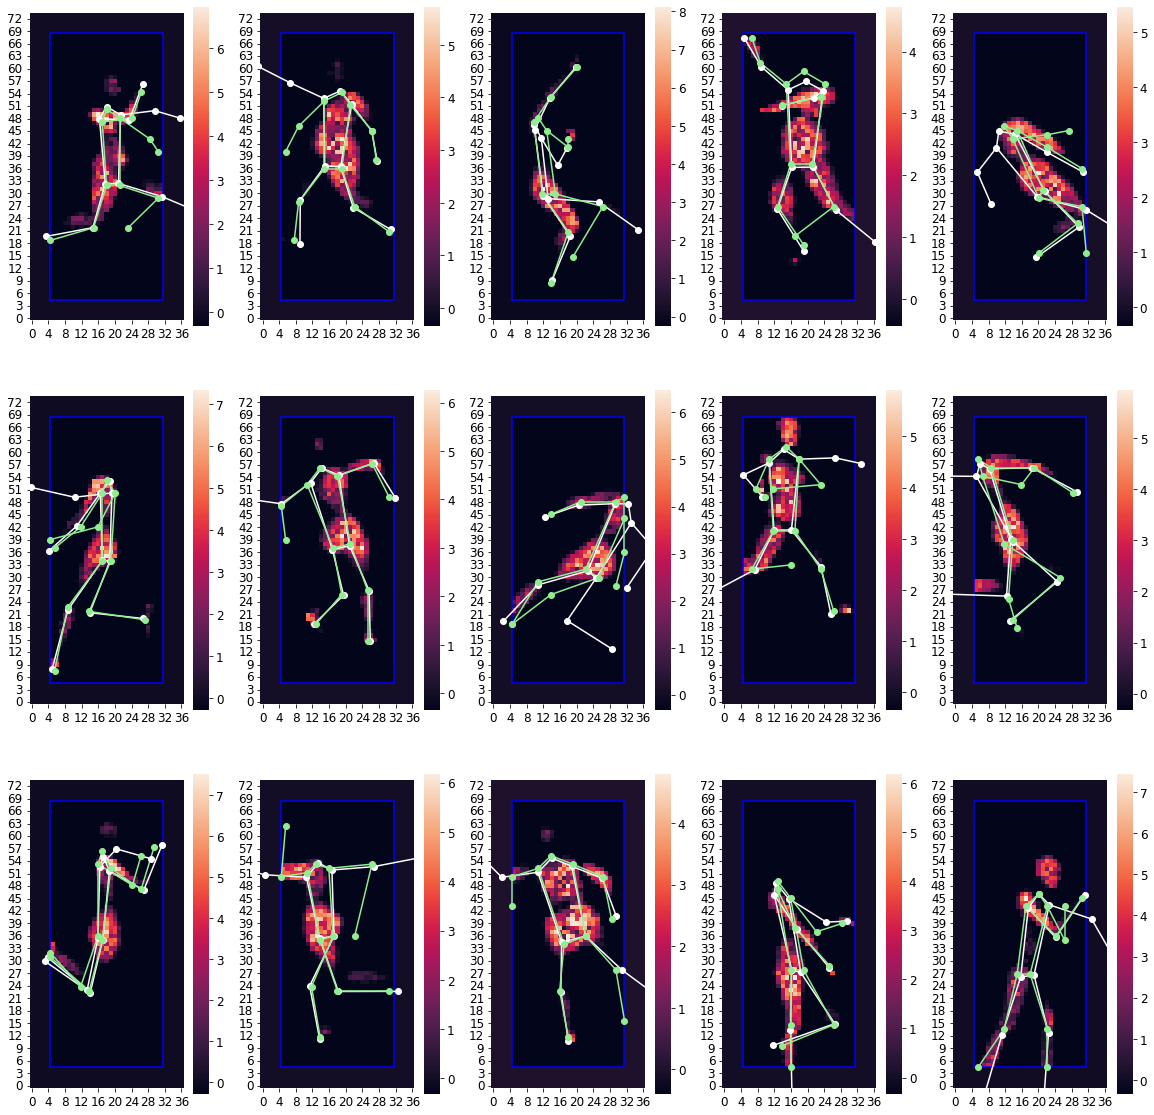

In [18]:
plot_examples()

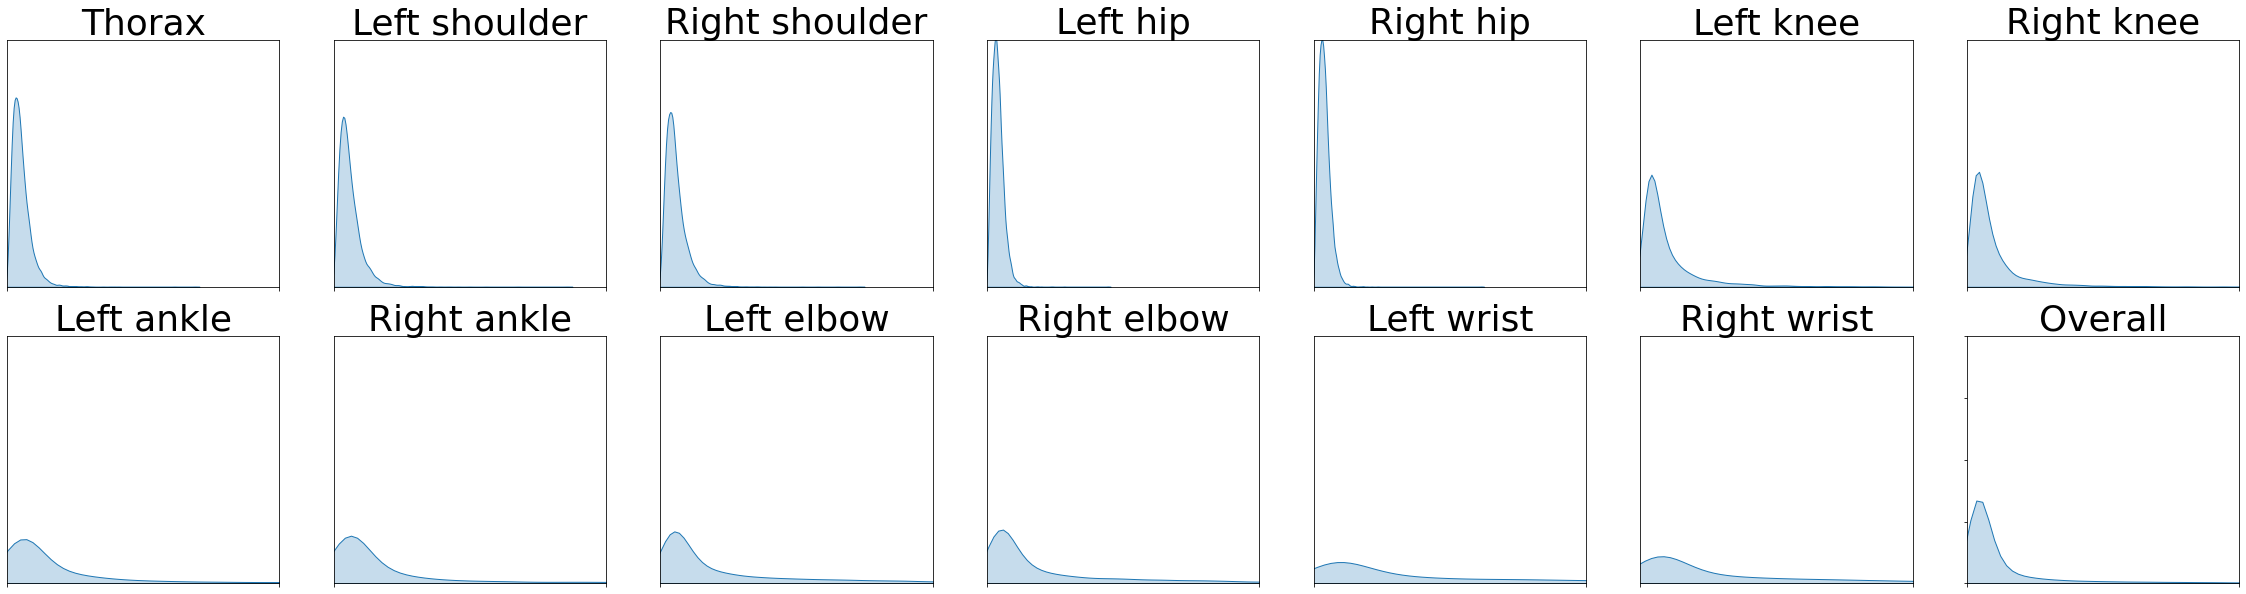

In [19]:
plot_per_joint_position_errors()

# SLP Dataset

In [20]:
dm = SLPDataModule(
    train_data_file = 'data/SLP/data-train.pkl',
    val_data_file = 'data/SLP/data-val.pkl',
    test_data_file = 'data/SLP/data-test.pkl',
    image_dir = 'data/SLP',
    input_format='ref',
    target_format='heatmaps',
    num_workers=8,
    input_transform = Stack([StdMeanNormalize(), Boolean(), HistogramEqualize()])
)
dm_skel = SLPDataModule(target_transform=SkeletonSLPToCommon())
evaluate()

In [21]:
print_metrics()

Mean per-joint position error: 7.433626174926758 cm ± 9.634069442749023 cm
PCP: 84.4612808227539 %
PCK: 86.8790512084961 %
Mean position error for Thorax: 3.719348669052124 cm ± 2.3926188945770264 cm
Mean position error for Left shoulder: 5.491171360015869 cm ± 3.7246131896972656 cm
Mean position error for Right shoulder: 5.334488868713379 cm ± 3.553243637084961 cm
Mean position error for Left hip: 4.298964023590088 cm ± 2.250873565673828 cm
Mean position error for Right hip: 4.330697536468506 cm ± 2.494748592376709 cm
Mean position error for Left knee: 5.339507579803467 cm ± 5.034482955932617 cm
Mean position error for Right knee: 5.875678062438965 cm ± 5.79067850112915 cm
Mean position error for Left ankle: 6.669571876525879 cm ± 9.226654052734375 cm
Mean position error for Right ankle: 6.233306407928467 cm ± 7.350188255310059 cm
Mean position error for Left elbow: 8.72673511505127 cm ± 11.052539825439453 cm
Mean position error for Right elbow: 8.620124816894531 cm ± 9.73630142211914

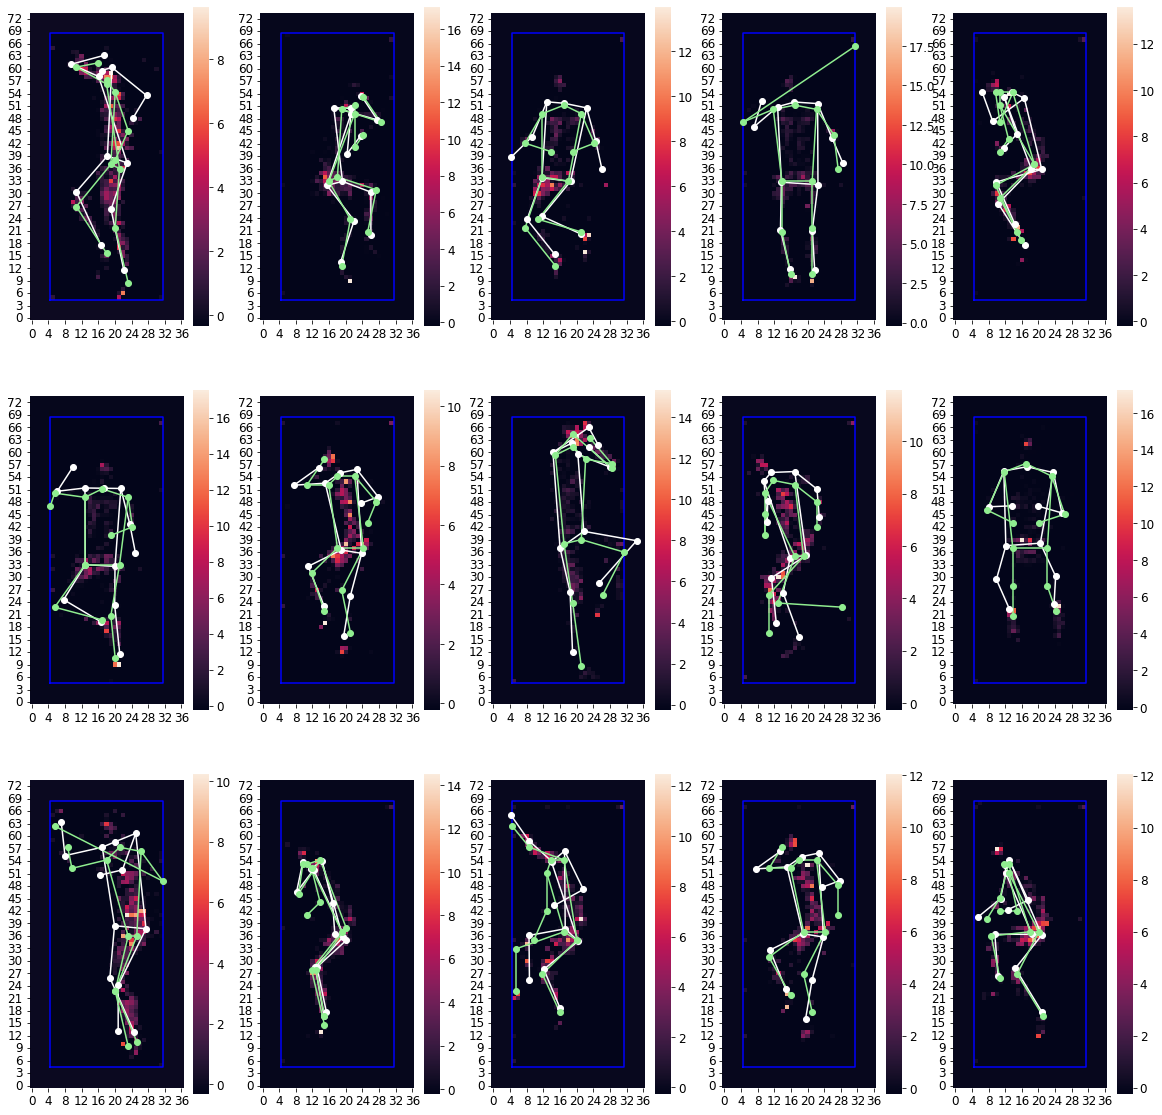

In [22]:
plot_examples()

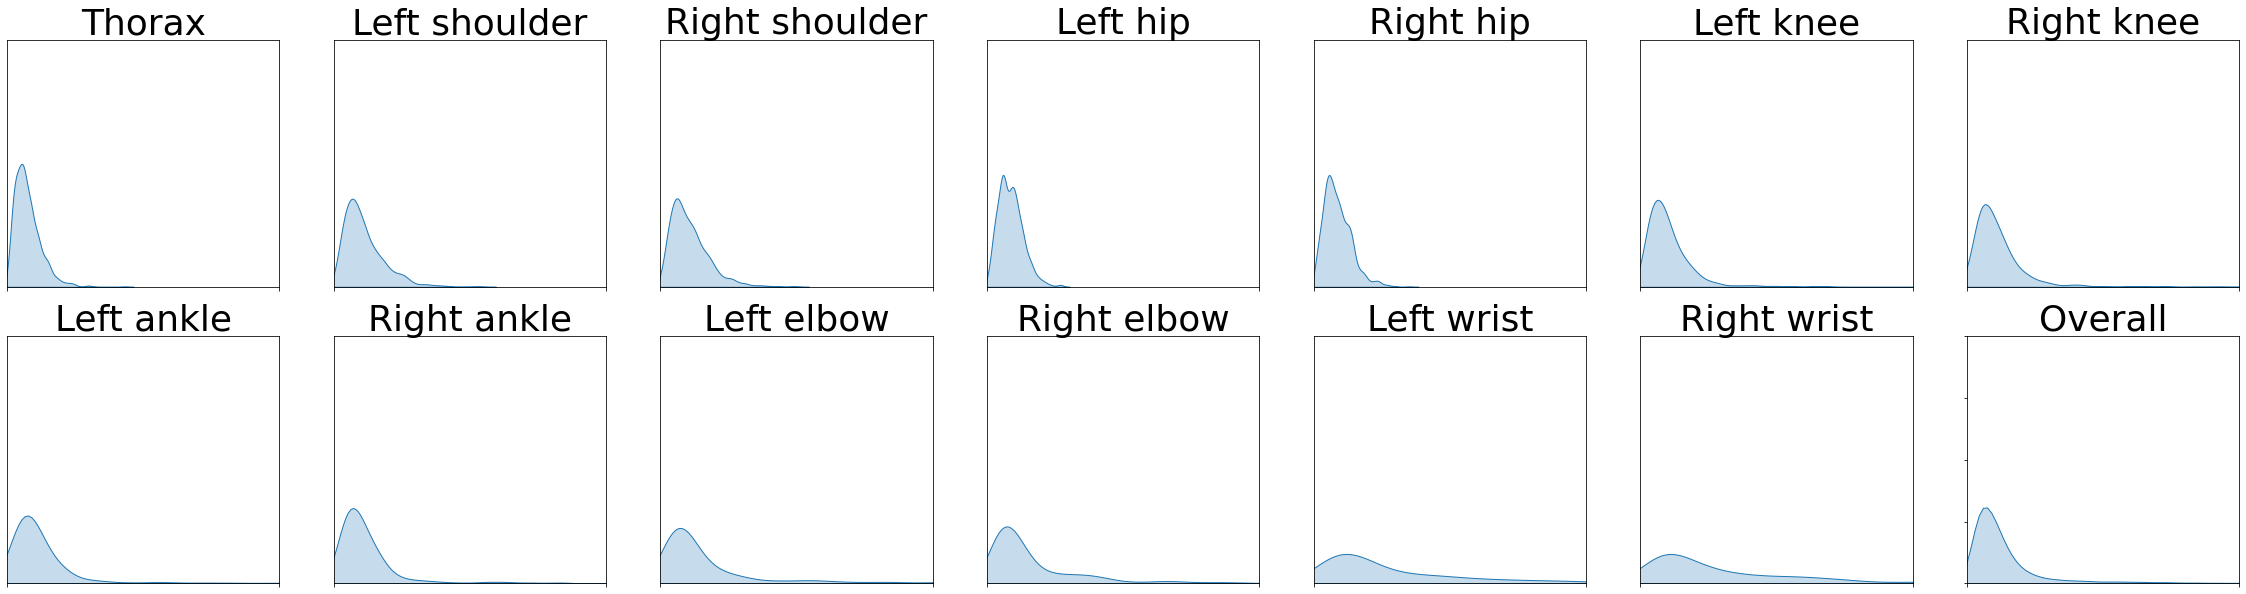

In [23]:
plot_per_joint_position_errors()

# Softline dataset

In [24]:
dm = SoftlineDataModule(
    num_workers=8,
    input_transform = Stack([StdMeanNormalize(), Boolean(), HistogramEqualize()]),
    target_transform = SkeletonToHeatmaps()
)
dm_skel = SoftlineDataModule(input_transform = Stack([StdMeanNormalize(), Boolean(), HistogramEqualize()]))
evaluate()

In [25]:
print_metrics()

Mean per-joint position error: 12.655719757080078 cm ± 15.956543922424316 cm
PCP: 74.5 %
PCK: 72.61539459228516 %
Mean position error for Thorax: 4.7284955978393555 cm ± 2.880995988845825 cm
Mean position error for Left shoulder: 5.852731704711914 cm ± 5.308164119720459 cm
Mean position error for Right shoulder: 4.5128326416015625 cm ± 2.8947970867156982 cm
Mean position error for Left hip: 8.395371437072754 cm ± 3.1796936988830566 cm
Mean position error for Right hip: 8.616460800170898 cm ± 2.954801321029663 cm
Mean position error for Left knee: 6.5053391456604 cm ± 6.263186931610107 cm
Mean position error for Right knee: 4.601596832275391 cm ± 2.8490028381347656 cm
Mean position error for Left ankle: 8.20361328125 cm ± 4.945621967315674 cm
Mean position error for Right ankle: 8.725990295410156 cm ± 3.6149048805236816 cm
Mean position error for Left elbow: 18.799402236938477 cm ± 17.671905517578125 cm
Mean position error for Right elbow: 16.333837509155273 cm ± 15.625617980957031 cm
M

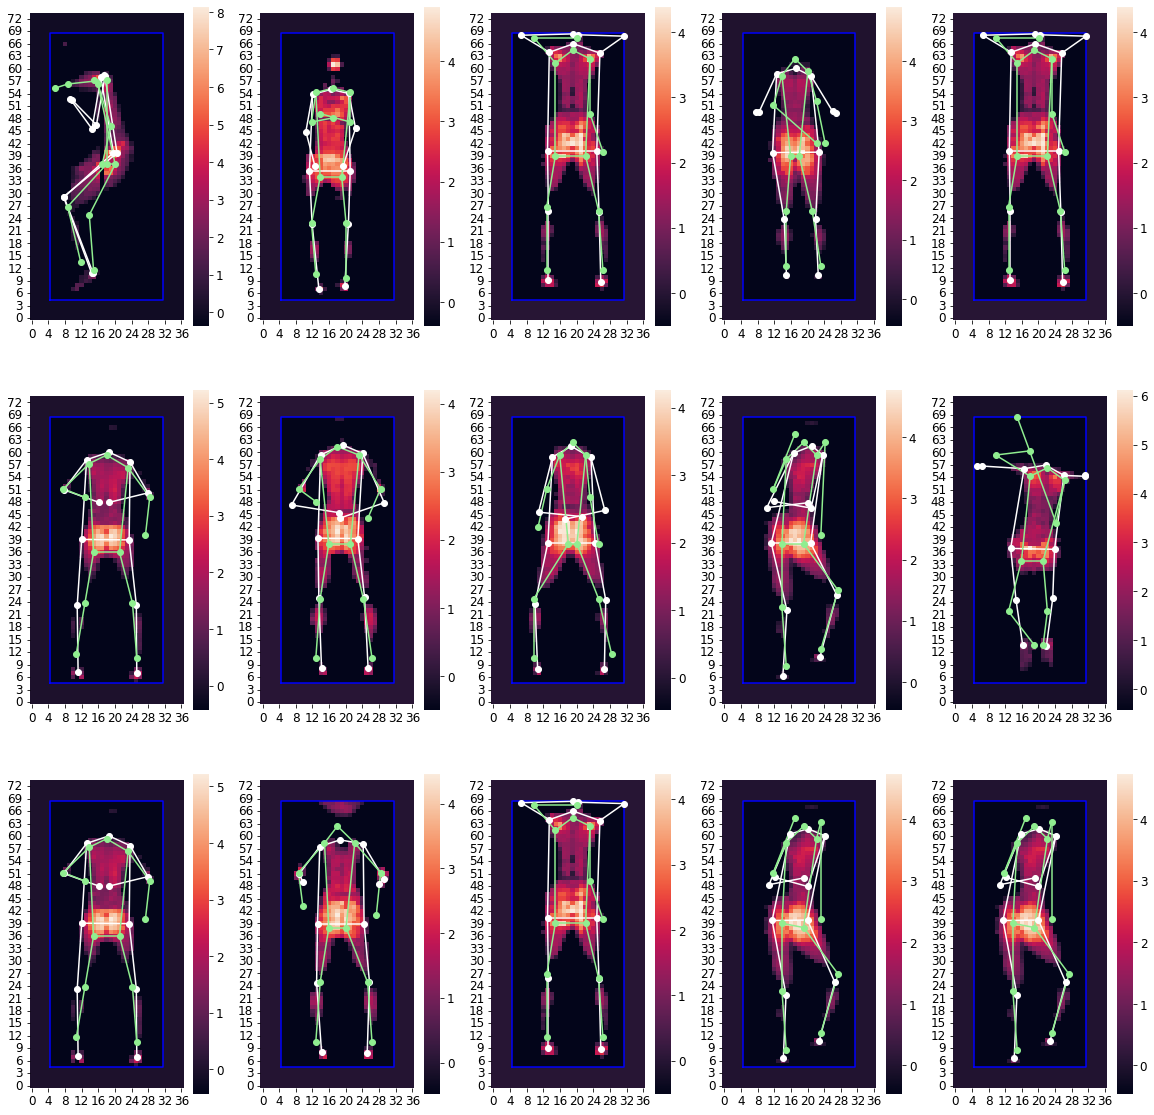

In [26]:
plot_examples()

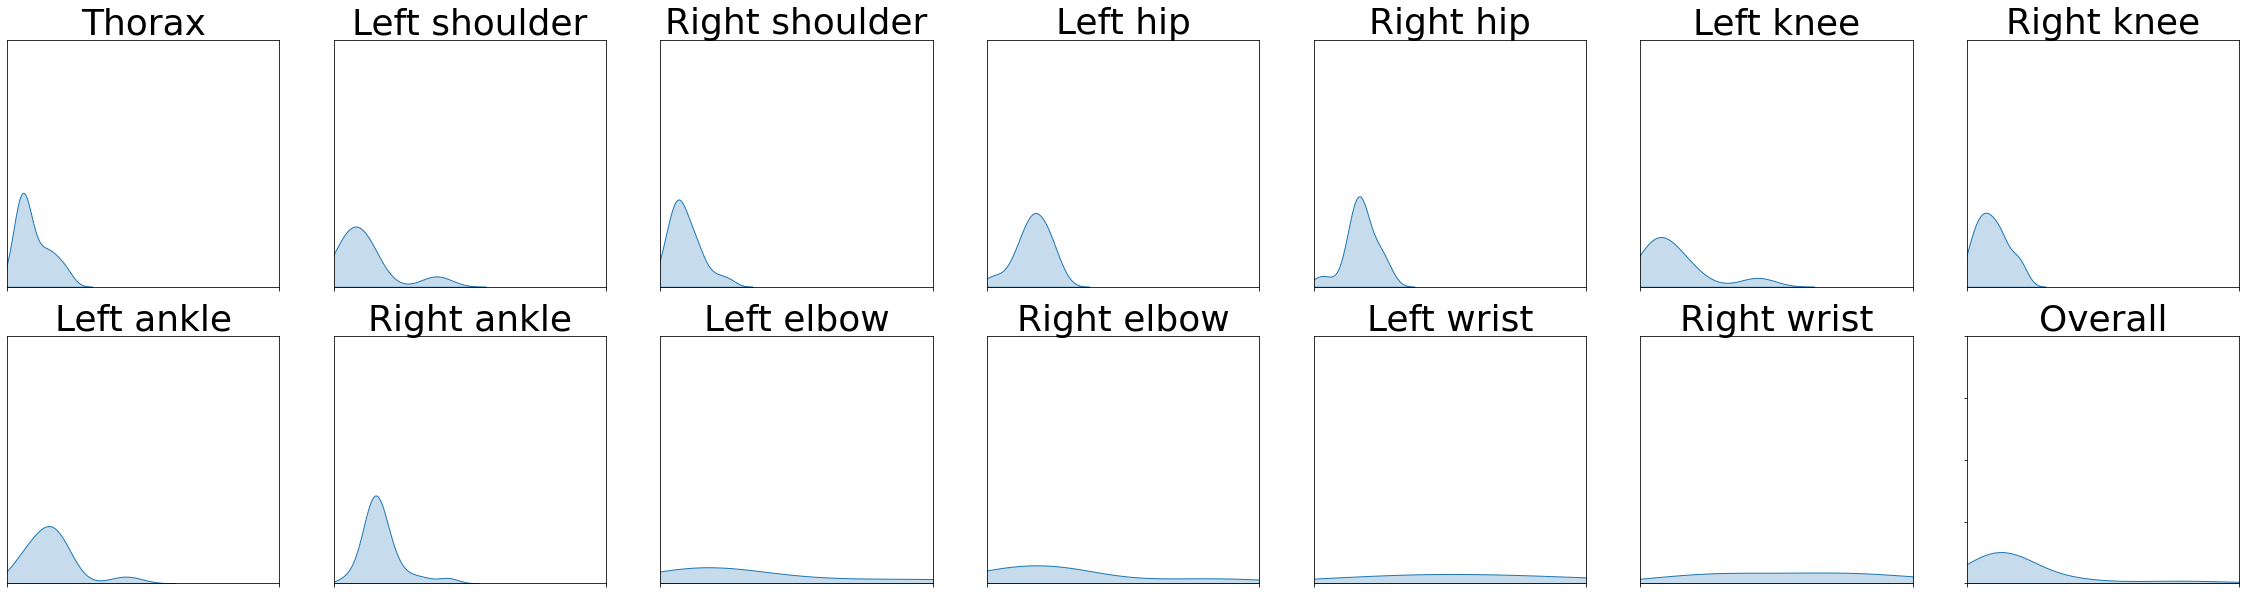

In [27]:
plot_per_joint_position_errors()